In [1]:
import pandas as pd 
import numpy as np 
from flaml import AutoML
import os
import shap 

In [2]:
base_path = "data/ROSMAP"
methy_path = os.path.join(base_path, "methy.csv")
mirna_path = os.path.join(base_path, "mirna.csv")
mrna_path = os.path.join(base_path, "mrna.csv")
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise ValueError("Data Not found")

In [3]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(351, 202) (351, 202) (351, 202)


In [4]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)

combined_df = pd.concat([methy_df_wos, mirna_df_wos, mrna_df_wos], axis=1)
combined_df['Label'] = methy_df['Label']
combined_df['Split'] = methy_df['Split']   


In [5]:
combined_df.head()

,ENSG00000161896.6,ENSG00000248714.2,ENSG00000242349.1,ENSG00000006831.9,ENSG00000261195.1,ENSG00000143409.11,ENSG00000140931.15,ENSG00000185499.11,ENSG00000101265.10,ENSG00000153048.6,...,hcmv-miR-UL70-3p,hsv1-miR-H1,hsv1-miR-H3,hsv1-miR-H8,kshv-miR-K12-2,kshv-miR-K12-4-5p,kshv-miR-K12-9,mcv-miR-M1-5p,Label,Split
1,0.181381,0.125337,0.094807,0.480227,0.246111,0.370208,0.214085,0.230799,0.427630,0.518057,...,0.269750,0.197881,0.201138,0.224232,0.225317,0.315773,0.337299,0.275999,0.0,1.0
2,0.132848,0.099462,0.149573,0.487058,0.377940,0.358607,0.300085,0.293175,0.400915,0.587203,...,0.269379,0.222585,0.247331,0.176573,0.163122,0.250090,0.365844,0.331535,1.0,1.0
3,0.111206,0.069999,0.127883,0.412276,0.198039,0.289383,0.200385,0.149573,0.374727,0.434148,...,0.315306,0.263122,0.269576,0.340817,0.252720,0.356404,0.393057,0.302595,1.0,1.0
4,0.085876,0.129139,0.071849,0.473626,0.231430,0.393466,0.184434,0.181821,0.411244,0.489082,...,0.274718,0.240122,0.210502,0.244531,0.277194,0.336700,0.344629,0.297727,0.0,1.0
5,0.068125,0.121434,0.008678,0.453002,0.150118,0.340528,0.201158,0.231745,0.390683,0.506201,...,0.270051,0.170695,0.247333,0.248524,0.217929,0.242820,0.346970,0.381820,0.0,1.0


In [6]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [7]:
final_combined_df  = combined_df.drop(correlation(combined_df, 0.8), axis=1)

In [8]:
final_combined_df.head()

,ENSG00000161896.6,ENSG00000248714.2,ENSG00000242349.1,ENSG00000006831.9,ENSG00000261195.1,ENSG00000143409.11,ENSG00000140931.15,ENSG00000185499.11,ENSG00000101265.10,ENSG00000153048.6,...,hcmv-miR-UL70-3p,hsv1-miR-H1,hsv1-miR-H3,hsv1-miR-H8,kshv-miR-K12-2,kshv-miR-K12-4-5p,kshv-miR-K12-9,mcv-miR-M1-5p,Label,Split
1,0.181381,0.125337,0.094807,0.480227,0.246111,0.370208,0.214085,0.230799,0.427630,0.518057,...,0.269750,0.197881,0.201138,0.224232,0.225317,0.315773,0.337299,0.275999,0.0,1.0
2,0.132848,0.099462,0.149573,0.487058,0.377940,0.358607,0.300085,0.293175,0.400915,0.587203,...,0.269379,0.222585,0.247331,0.176573,0.163122,0.250090,0.365844,0.331535,1.0,1.0
3,0.111206,0.069999,0.127883,0.412276,0.198039,0.289383,0.200385,0.149573,0.374727,0.434148,...,0.315306,0.263122,0.269576,0.340817,0.252720,0.356404,0.393057,0.302595,1.0,1.0
4,0.085876,0.129139,0.071849,0.473626,0.231430,0.393466,0.184434,0.181821,0.411244,0.489082,...,0.274718,0.240122,0.210502,0.244531,0.277194,0.336700,0.344629,0.297727,0.0,1.0
5,0.068125,0.121434,0.008678,0.453002,0.150118,0.340528,0.201158,0.231745,0.390683,0.506201,...,0.270051,0.170695,0.247333,0.248524,0.217929,0.242820,0.346970,0.381820,0.0,1.0


In [9]:
def get_train_test(df):
    train_df = df[df["Split"]==1].drop("Split", axis=1)
    test_df = df[df["Split"]==0].drop("Split", axis=1)
    y_train = train_df.pop("Label")
    y_test = test_df.pop("Label")
    return (train_df.values, y_train.values.astype("int32")), (test_df.values, y_test.values.astype("int32"))


In [10]:
def automl_predict(train_data, test_data, modality_type, time_budget = int(2*60)):
    automl = AutoML()

    automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": f"automl_logs/{modality_type}.log",
    }
    automl.fit(X_train=train_data[0], y_train=train_data[1],
        **automl_settings)
    predictions = automl.predict(test_data[0])
    accuracy = np.where(predictions == test_data[1], 1, 0).sum()/len(predictions)
    estimator = automl.model.estimator
    return estimator, accuracy


In [11]:
combined_train, combined_test = get_train_test(final_combined_df)


In [12]:
combined_train[0], combined_train[1]

(array([[0.18138132, 0.12533673, 0.094807  , ..., 0.31577263, 0.3372988 ,
         0.27599872],
        [0.13284753, 0.09946152, 0.14957318, ..., 0.25008951, 0.36584444,
         0.33153513],
        [0.11120613, 0.06999883, 0.12788265, ..., 0.35640375, 0.39305656,
         0.30259524],
        ...,
        [0.170412  , 0.08671085, 0.1646087 , ..., 0.39925214, 0.40265504,
         0.22076094],
        [0.0932226 , 0.11330874, 0.21895701, ..., 0.29786439, 0.34499124,
         0.30081847],
        [0.12661513, 0.16559176, 0.10835566, ..., 0.31176493, 0.33003293,
         0.25843713]]),
 array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0

In [13]:
methy_estimator, methy_accuracy = automl_predict(combined_train, combined_test, "combined")
print(methy_accuracy)
print(methy_estimator)

[flaml.automl.logger: 12-21 12:03:56] {1679} INFO - task = classification
[flaml.automl.logger: 12-21 12:03:56] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-21 12:03:56] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-21 12:03:56] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 12-21 12:03:56] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-21 12:03:56] {2344} INFO - Estimated sufficient time budget=3741s. Estimated necessary time budget=86s.
[flaml.automl.logger: 12-21 12:03:56] {2391} INFO -  at 0.4s,	estimator lgbm's best error=0.3673,	best estimator lgbm's best error=0.3673
[flaml.automl.logger: 12-21 12:03:56] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-21 12:03:57] {2391} INFO -  at 0.7s,	estimator lgbm's best error=0.3673,	best estimator lgbm's best error=0.3673
[flaml.automl.logger: 12-21 12:03:

In [17]:
explainer = shap.TreeExplainer(methy_estimator)
shap_values = explainer.shap_values(combined_train[0])

[12:07:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


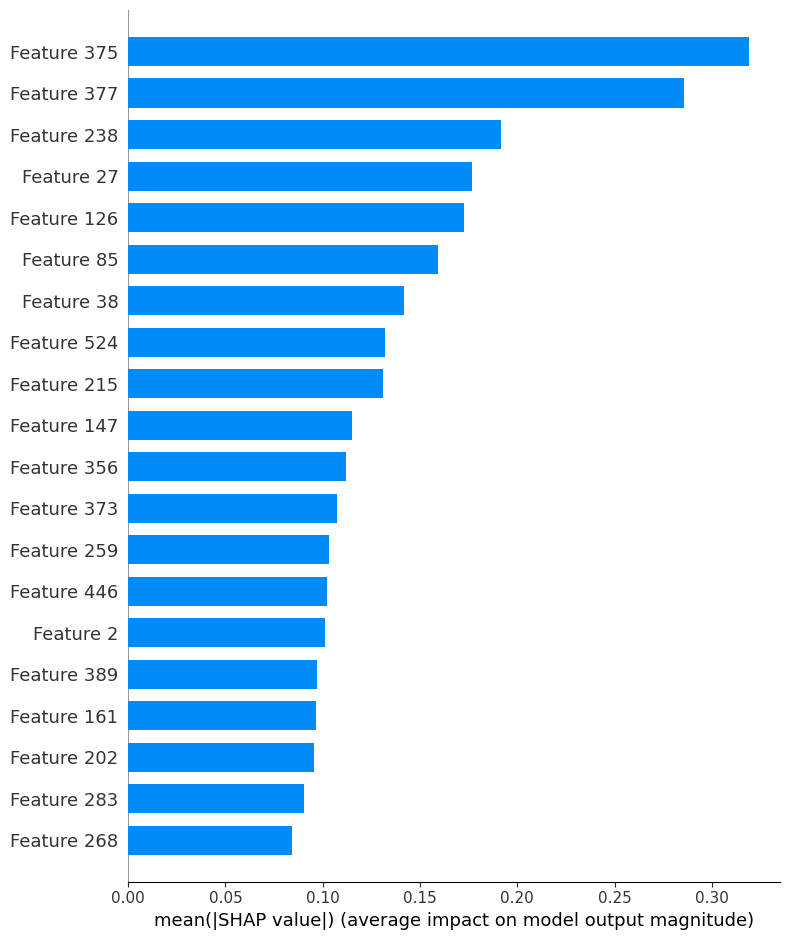

In [19]:
shap.summary_plot(shap_values, combined_train[0], plot_type='bar', show=False)